# 1. define a graph instance

In [1]:
import numpy as np
import igraph
EPS=1e-6

def to_igraph(G):
    G = igraph.Graph(list(G), directed=True)
    G.degree(mode='in')
    for v in G.vs:
        v['name'] = v['label'] = 'v' + str(v.index)
        v['color'] = 'pink'
    return G

N, M = 8, 11
G = np.array([(0,1), (0,2), (1, 0), (2,3), (3,4), (4,2), (2,5), (5,0), (6,3), (5,6), (7, 0)])
iG = to_igraph(G)
print(iG)
igraph.plot(iG, layout=iG.layout('kk'), bbox=(0, 0, 500, 200))

IGRAPH DN-- 8 11 --
+ attr: color (v), label (v), name (v)
+ edges (vertex names):
v0->v1, v0->v2, v1->v0, v2->v3, v3->v4, v4->v2, v2->v5, v5->v0, v6->v3,
v5->v6, v7->v0


In [2]:
# think graph have no island vertex, if have we move it out first, cause it have 0 similiar with any other point
def to_indegree_graph(G, n):
    in_G = [None] * n
    for i in range(n): in_G[i] = []
        
    for e in G:
        in_G[e[1]].append(e[0])
    return in_G

in_G = to_indegree_graph(G, N)
print(in_G)

[[1, 5, 7], [0], [0, 4], [2, 6], [3], [2], [5], []]


# 2. simrank

## 2.1 simrank 定义
![](../_image/bigdata_3simrank1.png)

### 2.1.1 dense matrix implement

In [3]:
def cal_similar(S, C, Ia, Ib):
    if len(Ia) == 0 or len(Ib) == 0: return 0
    k = 1.0 * C / len(Ia) / len(Ib)
    s = 0
    for i in range(len(Ia)):
        for j in range(len(Ib)):
            s += S[Ia[i], Ib[j]] * k
    return s

def cal_S(in_G, max_iters=100, C=0.6, M_type=np.eye):
    update = 1
    iters = 0
    N = len(in_G)
    S = M_type(N)
    oldS = M_type(N)
    
    while update > EPS and iters < max_iters:
        update = 0.
        for a in range(N-1):
            for b in range(a+1, N):
                S[b, a] = S[a, b] = cal_similar(oldS, C, in_G[a], in_G[b])
                update += abs(S[a, b] - oldS[a, b])
        iters += 1
        oldS[:, :] = S
    return S, iters

S, iters = cal_S(in_G, 100, 0.8)
print(iters)
print(np.round(S, 3))

34
[[1.    0.049 0.05  0.087 0.152 0.135 0.277 0.   ]
 [0.049 1.    0.461 0.131 0.069 0.04  0.108 0.   ]
 [0.05  0.461 1.    0.149 0.064 0.045 0.102 0.   ]
 [0.087 0.131 0.149 1.    0.073 0.441 0.033 0.   ]
 [0.152 0.069 0.064 0.073 1.    0.119 0.353 0.   ]
 [0.135 0.04  0.045 0.441 0.119 1.    0.036 0.   ]
 [0.277 0.108 0.102 0.033 0.353 0.036 1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]


### 2.1.2 sparse matrix implement

In [10]:
class SparseMatrix:
    def __init__(self, num_vertex):
        self._dict = {}
        for vid in range(num_vertex):
            self._dict[(vid, vid)] = 1.0
        self.num_vertex = num_vertex
    
    def __getitem__(self, idx):
        if idx in self._dict:
            return self._dict[idx]
        else:
            return 0
    
    def __setitem__(self, idx, v):
        self._dict[idx] = v
        
    def __str__(self):
        S = np.eye(self.num_vertex)
        for key in self._dict:
            S[key] = self._dict[key]
        return str(np.round(S, 3))
    
    def __iadd__(self, S):
        for key in set(self._dict.keys()) | set(S._dict.keys()):
            self[key] = self[key] + S[key]
        return self
    
    def __isub__(self, S):
        for key in set(self._dict.keys()) | set(S._dict.keys()):
            self[key] = self[key] - S[key]
        return self
    
    def __itruediv__(self, v):
        for key in set(self._dict.keys()) | set(S._dict.keys()):
            self[key] = self[key] / v
        return self
    
    def __truediv__(self, v):
        S = SparseMatrix(self.num_vertex)
        for key in set(self._dict.keys()) | set(S._dict.keys()):
            S[key] = self[key] / v
        return S
    
    @classmethod
    def abs_sum(cls, self):
        s = 0
        for key, value in self._dict.items():
            s += abs(value)
        return s
    
S = SparseMatrix(10)  

S, iters = cal_S(in_G, 100, 0.6, np.eye)
print(iters)
print(np.round(S, 3))

S, iters = cal_S(in_G, 100, 0.6, SparseMatrix)
print(iters)
print(S)

13
[[1.    0.017 0.014 0.038 0.075 0.066 0.202 0.   ]
 [0.017 1.    0.322 0.065 0.023 0.009 0.04  0.   ]
 [0.014 0.322 1.    0.063 0.017 0.01  0.031 0.   ]
 [0.038 0.065 0.063 1.    0.02  0.309 0.005 0.   ]
 [0.075 0.023 0.017 0.02  1.    0.038 0.186 0.   ]
 [0.066 0.009 0.01  0.309 0.038 1.    0.006 0.   ]
 [0.202 0.04  0.031 0.005 0.186 0.006 1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]
13
[[1.    0.017 0.014 0.038 0.075 0.066 0.202 0.   ]
 [0.017 1.    0.322 0.065 0.023 0.009 0.04  0.   ]
 [0.014 0.322 1.    0.063 0.017 0.01  0.031 0.   ]
 [0.038 0.065 0.063 1.    0.02  0.309 0.005 0.   ]
 [0.075 0.023 0.017 0.02  1.    0.038 0.186 0.   ]
 [0.066 0.009 0.01  0.309 0.038 1.    0.006 0.   ]
 [0.202 0.04  0.031 0.005 0.186 0.006 1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]


## 2.2 Monte Calor

In [ ]:
from random import random
EPS = 1e-6

def abs_sum(S):
    return np.sum(np.abs(S))

def MonteCarla(in_graph, K, L, C, stdS=None, M_type=np.eye, abs_sum=abs_sum):
    def random_choose_next_path(i):
        if len(in_graph[i]) == 0: return -1;
        j = int(random() * len (in_graph[i]))
        return in_graph[i][j]
    
    def cal_similar():   
        S = M_type(len(in_graph))
        meet_nodes = [[i] for i in range(len(in_graph))]
        for l in range(L):
            # all walker move one step
            new_meet_nodes = [[] for i in range(len(in_graph))]
            for cur_node, nodes in enumerate(meet_nodes):
                for node in nodes:
                    j = random_choose_next_path(cur_node)
                    if j >= 0:
                        new_meet_nodes[j].append(node)
            meet_nodes = new_meet_nodes

            # cal similar
            for cur_node, nodes in enumerate(meet_nodes):
                for i in range(len(nodes)-1):
                    for j in range(i+1, len(nodes)):
                        node_i, node_j = nodes[i], nodes[j]
                        if S[node_i, node_j] <= EPS:
                            S[node_j, node_i] = S[node_i, node_j] = C ** (l+1)
        return S
    
    if stdS is not None: res = []
    N = len(in_graph)
    S = M_type(N)
    S -= M_type(N)
    for k in range(K):
        S += cal_similar()
        if stdS is not None:
            SS = S / (k+1)
            SS -= stdS
            res.append(abs_sum(SS))
    S /= K
    return S, res
 
stdS, iters = cal_S(in_G, 100, 0.6)
S, res = MonteCarla(in_G, 200, 6, 0.6, stdS)
print(S)
import matplotlib.pyplot as plt
plt.plot(range(40, len(res)), res[40:])
plt.show()

[[1.    0.014 0.015 0.04  0.068 0.061 0.203 0.   ]
 [0.014 1.    0.336 0.051 0.021 0.005 0.046 0.   ]
 [0.015 0.336 1.    0.052 0.013 0.011 0.034 0.   ]
 [0.04  0.051 0.052 1.    0.022 0.331 0.003 0.   ]
 [0.068 0.021 0.013 0.022 1.    0.04  0.176 0.   ]
 [0.061 0.005 0.011 0.331 0.04  1.    0.005 0.   ]
 [0.203 0.046 0.034 0.003 0.176 0.005 1.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]


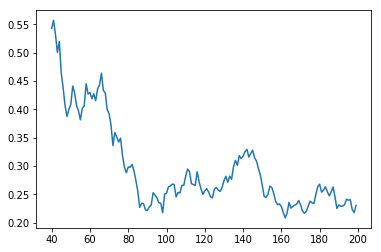

In [11]:
stdS, iters = cal_S(in_G, 100, 0.6, SparseMatrix)
S, res = MonteCarla(in_G, 200, 6, 0.6, stdS, SparseMatrix, SparseMatrix.abs_sum)
print(S)
import matplotlib.pyplot as plt
plt.plot(range(40, len(res)), res[40:])
plt.show()

## 2.3 naive simrank
迭代公式
![](../_image/bigdata_3simrank2.png)
S是相似度矩阵。Q是转移概率矩阵，它的每一列和为1，如果从节点i可以转移到节点j，并且这样的节点i一共有n个，则Qi,j=1n</br>

收敛速度
![](../_image/bigdata_3simrank3.png)

In [77]:
def create_Q(in_G):
    N = len(in_G)
    Q = np.zeros(shape=(N, N))
    for j, i_set in enumerate(in_G):
        if len(i_set) > 0:
            Q[i_set, j] = 1.0 / len(i_set)
        else:
            Q[j, j] = 0
    return np.mat(Q)

def cal_naive_simrank(in_G, K, C=0.6, res=None):
    N = len(in_G)
    S = np.mat((1-C) * np.eye(N))
    Q = create_Q(in_G)
    res = []
    for k in range(K):
        temp = C * Q.T * S * Q + np.mat((1-C)*np.eye(N))
        res.append(np.sum(np.abs(S-temp)))
        S = temp
        if res[-1] <= EPS:
            return S, res
    return S, res

[[0.306 0.016 0.018 0.028 0.063 0.044 0.141 0.   ]
 [0.016 0.444 0.147 0.063 0.023 0.014 0.035 0.   ]
 [0.018 0.147 0.393 0.064 0.023 0.016 0.038 0.   ]
 [0.028 0.063 0.064 0.416 0.03  0.172 0.012 0.   ]
 [0.063 0.023 0.023 0.03  0.533 0.051 0.138 0.   ]
 [0.044 0.014 0.016 0.172 0.051 0.514 0.013 0.   ]
 [0.141 0.035 0.038 0.012 0.138 0.013 0.611 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.2  ]]


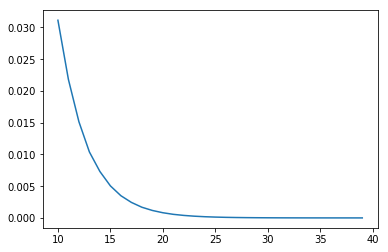

In [78]:
S , res = cal_naive_simrank(in_G, 100, 0.8)
plt.plot(range(10, len(res)), res[10: ])
print(np.round(S, 3))

In [4]:
print(S)

[[1.       0.       0.       ... 0.       0.       0.      ]
 [0.       1.       0.792    ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 1.       0.24727  0.145408]
 [0.       0.       0.       ... 0.       1.       0.226189]
 [0.       0.       0.       ... 0.       0.       1.      ]]


# 3 test big data

In [7]:
def load_in_Graph(path):
    f = open(path)
    lines = f.readlines()
    f.close()
    for i, line in enumerate(lines):
        if i == 0: 
            num_v = int(line[:-1])
            in_G = [[] for i in range(num_v)]
        elif i == 1: num_e = int(line[:-1])
        else:
            substrs = line.split(" ")
            if len(substrs) < 2: continue
            s, t = int(substrs[0]), int(substrs[1])
            in_G[t].append(s)
    return in_G
in_G = load_in_Graph("/home/hui/github/BigDataWork/bigwork/SimRank/Input/testgraph")
print(in_G)

[[1, 5, 7], [0], [0, 4], [2, 6], [3], [2], [5], []]


In [24]:
in_G = load_in_Graph("/home/hui/github/BigDataWork/bigwork/SimRank/Input/facebookcombined")
from functools import reduce
num_e = reduce(lambda x, y: len(x) + len(y) if isinstance(x, list) else x + len(y), in_G)

In [9]:
S, iters = cal_S(in_G, 100, 0.6, SparseMatrix)
print(iters)
print(S)

2
[[1.    0.    0.    ... 0.    0.    0.   ]
 [0.    1.    0.6   ... 0.    0.    0.   ]
 [0.    0.6   1.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 1.    0.119 0.077]
 [0.    0.    0.    ... 0.119 1.    0.103]
 [0.    0.    0.    ... 0.077 0.103 1.   ]]


In [11]:
S, iters = cal_S(in_G, 100, 0.6)
print(iters)
print(S)

2
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.6        ... 0.         0.         0.        ]
 [0.         0.6        1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.11882935 0.07740604]
 [0.         0.         0.         ... 0.11882935 1.         0.10313502]
 [0.         0.         0.         ... 0.07740604 0.10313502 1.        ]]


In [14]:
S, res = MonteCarla(in_G, 200, 6, 0.6, S)

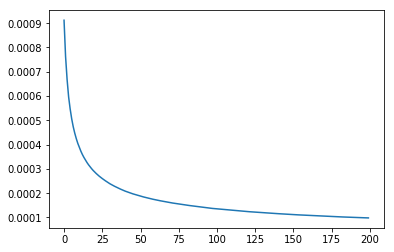

In [23]:
res = np.array(res) / num_e
plt.plot(range(len(res)), res)

In [238]:
def reverse_edge(path):
    reverse_edge = []
    f = open(path)
    lines = f.readlines()
    f.close()
    for i, line in enumerate(lines):
        if i == 0: num_v = line
        elif i == 1: num_e = line
        else:
            substrs = line.split(" ")
            reverse_edge.append((int(substrs[1]), int(substrs[0])))
        
    f = open(path + "_reverse", 'w')
    f.write(num_v + num_e)
    for edge in sorted(reverse_edge):
        f.write("{} {}\n".format(*edge))
        
    #import os
    #! hash-partitioner.pl Input/testgraph_reverse 4
    
reverse_edge("/home/hui/github/BigDataWork/bigwork/SimRank/Input/testgraph")

In [165]:
reverse_edge("/home/hui/github/BigDataWork/bigwork/SimRank/Input/facebookcombined")
! hash-partitioner.pl /home/hui/github/BigDataWork/bigwork/SimRank/Input/facebookcombined_reverse 4

/bin/sh: 1: hash-partitioner.pl: not found


```
1. input:
    1.1 输入格式 edge reverse
    1.3 Inputformatter: change vertex/msg size, change load_graph
    1.4 change OutputFormatter
    1.2 compute superstep==0 init vertex value (Vertex use pointer, set to NULL and not use same in loadGraph and init in superstep==0)
    1.3 add recieve merge msg code
        Messges<Msg>* --> 
    1.4 add send msg code
    1.5 similar matrix only save retangle part. sim[i][j] j = i+1:N, j>i saved
```

graphLite 常规报错
1. 1.1 常用工具 kill_graphlite.sh
   1.2 常用输出控制
   ```
    ofstream cout;
    cout.open("/home/hui/github/BigDataWork/bigwork/SimRank/log.txt", ios_base::app);
    cout << getVertexId() << " done" << endl;
   ```

2. 错在 Input,很可能是输入的文件路径错误.
```
init
manageSuperstep
Sender: connect: Connection refused
```

3. pmsgs->m_vector_size == 0时候(没有收到消息), 调用了pmsgs->getValue(), 卡死在那里

4. use i+1<received_msg.size() inplace i<received_msg.size()-1, cuase size is uint, uint(0-1) get uing::max()

## test

In [21]:
import numpy as np
from tqdm import tqdm
prefix = '/home/hui/github/BigDataWork/bigwork/SimRank/'

def getS(path, N):
    S = np.eye(N)
    f = open(path)
    n = 0
    for line in f:
        substrs = line[:-1].split(' ')
        if len(substrs) < 3:
            continue
        s, t, v = substrs
        s, t, v = int(s), int(t), float(v)
        if s > t:
            print("error", s, t, path)
        S[s, t] = v
        n += 1
    f.close()
    return S, n
 
def compute(K, N, stdS, logpath):
    Sold = np.eye(N)
    update = []
    error = []
    for i in tqdm(range(1, K+1)):
        path = '{}/{}.txt'.format(logpath, 10*i)
        S, n = getS(path, N)
        update.append(np.max(np.abs(S - Sold)))
        error.append(np.sum(np.abs(S - stdS) / N))
        Sold[:, :] = S[:, :]
    return update, error, n

def get_rank_tS(path):
    lines = open(path).readlines()
    tS = [None] * len(lines)
    for i, line in enumerate(lines):
        substrs = line[:-1].split(' ')
        if len(substrs) < 3:
            continue
        s, t, v = substrs
        s, t, v = int(s), int(t), float(v)
        if s > t:
            print("error", s, t, path)
        tS[i] = (-v, s, t)
        
    tS.sort(key=lambda x: x)
    return tS

def get_rank_S(tS, n, N):
    if n > 0: tS = tS[:n]
    S = np.zeros(shape=(N, N))
    for i, (v, s, t) in enumerate(tS):
        S[s, t] = i
    return S

def compute_rank(K, N, stdtS, logpath):
    def tial_rank_dis(N, n):
        tail_n = N * (N-1) / 2 - n
        # (0 + 1 + 2 + ... tail_n) / (N*(N-1))/2
        return tail_n * (tail_n - 1) / N / (N+1)
    
    Sold, oldtS_n = np.zeros(shape=(N, N)), 0
    stdS, stdn = get_rank_S(stdtS, len(stdtS), N), len(stdtS)
    update = []
    error = []
    res = {'update2': [], 'error2': []}
    for i in tqdm(range(1, K+1)):
        path = '{}/{}.txt'.format(logpath, 10*i)
        tS = get_rank_tS(path)
        
        n = min([len(tS), oldtS_n])
        d = abs(len(tS) - oldtS_n)
        S = get_rank_S(tS, n, N)
        tmp = (np.sum(np.abs((S-Sold))) + d * (d-1) / 2)
        update.append(tmp/(n+d))
        res['update2'].append(tmp/N/(N+1) * 2)
        
        n = min([len(tS), stdn])
        d = abs(len(tS) - stdn)
        S = get_rank_S(tS, n, N)
        tmp = (np.sum(np.abs((S-stdS))) + d * (d-1) / 2)
        error.append(tmp/(n+d))
        res['error2'].append(tmp/N/(N+1) * 2)
        
        Sold[:, :] = get_rank_S(tS, len(tS), N)
        oldtS_n = len(tS)
    return update, error, res

### test graph
```
EPS = 1e-6
test_sync: 0.000107s  K = 35
test_async: 0.000122s K = 21

K, L, C = 100, 6, 0.8
24.92s
```

In [22]:
K, N = 10, 8
Sa, San = getS(prefix + "log/naive_simrank_test_async.txt", N)
Ss, Ssn = getS(prefix + "log/naive_simrank_test_sync.txt", N)
update, error, n = compute(K, N, Ss, prefix + "/log/testgraph")
update, error = np.array(update) * N / n, np.array(error) * N / n

tSa = get_rank_tS(prefix + "log/naive_simrank_test_async.txt")
tSs = get_rank_tS(prefix + "log/naive_simrank_test_sync.txt")
rank_update, rank_error, res = compute_rank(K, N, tSs, prefix + "/log/testgraph")

100%|██████████| 10/10 [00:00<00:00, 8994.86it/s]


In [23]:
tSa1 = get_rank_tS(prefix + "log/naive_simrank_test_async.txt")
tSa2 = get_rank_tS(prefix + "log/testgraph/100.txt")
n = min([len(tSa1), len(tSa2)])
d = abs(len(tSa1) - len(tSa2))
Sa1 = get_rank_S(tSa1, n, N)
Sa2 = get_rank_S(tSa2, n, N)
print((np.sum(np.abs((Sa1-Sa2))) + d * (d-1) / 2)/n)

4.722222222222222


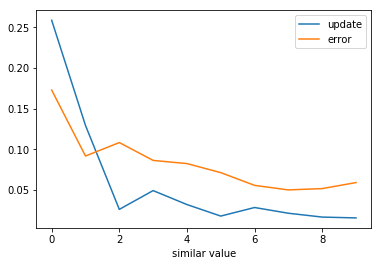

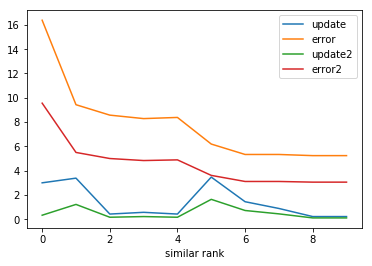

In [24]:
import matplotlib.pyplot as plt
plt.plot(range(len(update)), update, label='update')
plt.plot(range(len(error)), error, label='error')
plt.legend()
plt.xlabel('similar value')
plt.show()

plt.plot(range(len(update)), rank_update, label='update')
plt.plot(range(len(error)), rank_error, label='error')
plt.plot(range(len(update)), res['update2'], label='update2')
plt.plot(range(len(error)), res['error2'], label='error2')
plt.legend()
plt.xlabel('similar rank')
plt.show()

### facebook
```
EPS = 1e-6
test_sync: 3586.19s  K = 21

0 38067.8
1 9455.28
2 41036.1
3 17052.4
4 12718.4
5 6769.23
6 2946.04
7 1067.19
8 334.399
9 91.5177
10 22.3637
11 5.0193
12 1.05391
13 0.209107
14 0.0391644
15 0.0068696
16 0.00111712
17 0.000167038
18 2.28455e-05
19 2.85119e-06
20 3.24539e-07

test_async: 389.623s K = 2

K, L, C = 100, 6, 0.8
52.41s

with log use time: 231.41s
```

In [49]:
K, N = 10, 4039
Sa, San = getS(prefix + "log/naive_simrank_facebook_async.txt", N)
Ss, Ssn = getS(prefix + "log/naive_simrank_facebook_sync.txt", N)
update, error, n = compute(K, N, Ss, prefix + "/log/facebook3")
update, error = np.array(update) * N / n, np.array(error) * N / n

#tSa = get_rank_tS(prefix + "log/naive_simrank_facebook_async.txt")
#tSs = get_rank_tS(prefix + "log/naive_simrank_facebook_sync.txt")
#rank_update, rank_error, res = compute_rank(K, N, tSs, prefix + "/log/facebook")

100%|██████████| 10/10 [00:38<00:00,  3.81s/it]


Text(0.5,0,'similar value')

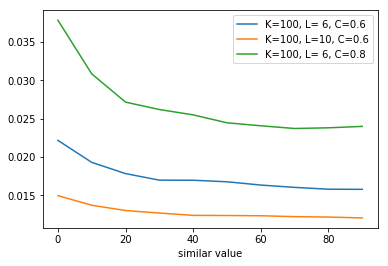

In [51]:
x = np.array(range(len(update3))) * 10
s, e = 0, 11
plt.plot(x[s:e], error1[s:e], label='K=100, L= 6, C=0.6')
plt.plot(x[s:e], error2[s:e], label='K=100, L=10, C=0.6')
plt.plot(x[s:e], error3[s:e], label='K=100, L= 6, C=0.8')
plt.legend()
plt.xlabel('similar value')

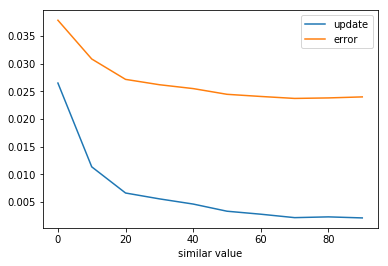

In [50]:
# 100 6 0.8
import matplotlib.pyplot as plt
x = np.array(range(len(update3))) * 10
s, e = 0, 11

plt.plot(x[s:e], update3[s:e]*50, label='update')
plt.plot(x[s:e], error3[s:e], label='error')
plt.legend()
plt.xlabel('similar value')
plt.show()

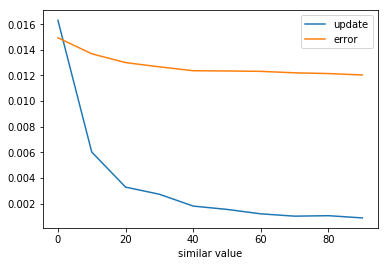

In [47]:
# 100 10 0.6
import matplotlib.pyplot as plt
x = np.array(range(len(update2))) * 10
s, e = 0, 11

plt.plot(x[s:e], update2[s:e]*50, label='update')
plt.plot(x[s:e], error2[s:e], label='error')
plt.legend()
plt.xlabel('similar value')
plt.show()

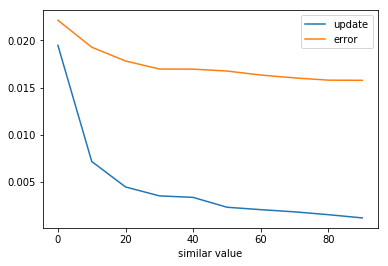

In [48]:
# 100 6 0.6

import matplotlib.pyplot as plt
x = np.array(range(len(update1))) * 10
s, e = 0, 11

plt.plot(x[s:e], update1[s:e]* 50, label='update')
plt.plot(x[s:e], error1[s:e], label='error')
plt.legend()
plt.xlabel('similar value')
plt.show()

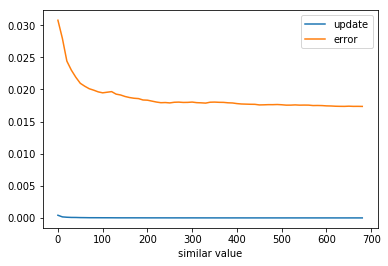

In [27]:
# 100 6 0.8

import matplotlib.pyplot as plt
x = np.array(range(len(update))) * 10
s, e = 0, 70

plt.plot(x[s:e], update[s:e], label='update')
plt.plot(x[s:e], error[s:e], label='error')
plt.legend()
plt.xlabel('similar value')
plt.show()

# plt.plot(x[s:e], rank_update[s:e], label='update')
# plt.plot(x[s:e], rank_error[s:e], label='error')
# plt.plot(x[s:e], res['update2'][s:e], label='update2')
# plt.plot(x[s:e], res['error2'][s:e], label='error2')
# plt.legend()
# plt.xlabel('similar rank')
# plt.show()

In [184]:
import struct
byte = open('/home/hui/github/BigDataWork/bigwork/SimRank/log.bin', 'rb').read()
# print(len(byte))
for i in range(2):
    s, t, v = struct.unpack('2Qd', byte[i*24:i*24+24])
    print(s, t, v)

0 1 0.52
100 99 0.33


## 1. 算法调研
### 1.1 simrank介绍 wiki
### 1.2 高效近似算法 http://www.cnblogs.com/zhangchaoyang/articles/4575809.html

## 2. 高效算法
### 2.1 Monte Carlo random working
### 2.2 GraphLite 实现的一些技巧
#### 2.2.1 edge reverse
#### 2.2.2 

## 3. 性能测试
```
实验环境
OS: ubuntu 16.04
CPU: Intel(R) Core(TM) i7-7700 CPU @ 3.60GHz 4核8线程
cache size: 8192 KB * 8
memory size: 32G
```

